# Introduction
This is a weather forecasting project on regional hourly historical weather data of Kolkata<br>
The main focus of this project is to 
- explore and analyze the weather of Kolkata
- showcase the power of lstm and deep learning in the field of weather forecasting in comparison with other traditional ML models

## Dataset -
data is collected from visual crossing weather API from rapidAPI
datalink - https://www.visualcrossing.com/weather/weather-data-services/kolkata/metric/2017-01-01/2023-01-01#
the data is the hourly weather data of Kolkata from 2017 to 2022
It contains 25 columns, namely - 
* 'Address',
* 'Date time',
* 'Minimum Temperature',
* 'Maximum Temperature',
* 'Temperature',
* 'Dew Point',
* 'Relative Humidity',
* 'Heat Index',
* 'Wind Speed',
* 'Wind Gust',
* 'Wind Direction',
* 'Wind Chill',
* 'Precipitation',
* 'Precipitation Cover',
* 'Snow Depth',
* 'Visibility',
* 'Cloud Cover',
* 'Sea Level Pressure',
* 'Weather Type',
* 'Latitude',
* 'Longitude',
* 'Resolved Address',
* 'Name',
* 'Info',
* 'Conditions'

# Imports

In [1]:
!pip install windrose

In [2]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras_tuner as kt
from sklearn.svm import SVR
from tensorflow import keras
from datetime import datetime
import matplotlib.pyplot as plt
from windrose import WindroseAxes
from itertools import combinations
from tensorflow.keras import layers
from kerastuner import RandomSearch
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, Dense, Activation, Dropout
from keras_tuner.engine.hyperparameters import HyperParameter
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_24/2778802180.py:14: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


In [3]:
path = "/kaggle/input/kolkata-weather-2017-2023-hourly/kolkata2017-2022.csv"
df = pd.read_csv(path)
df.head()

,Unnamed: 0,Address,Date time,Minimum Temperature,Maximum Temperature,Temperature,Dew Point,Relative Humidity,Heat Index,Wind Speed,...,Visibility,Cloud Cover,Sea Level Pressure,Weather Type,Latitude,Longitude,Resolved Address,Name,Info,Conditions
0,0,kolkata,01/01/2017 00:00:00,62.6,62.6,62.6,59.0,88.01,NaN,0.0,...,1.2,0.0,1015.0,Mist,22.5705,88.3712,"Kolkata, WB, India","Kolkata, WB, India",NaN,Clear
1,1,kolkata,01/01/2017 01:00:00,60.8,60.8,60.8,59.0,93.79,NaN,0.0,...,1.2,0.0,1015.0,Mist,22.5705,88.3712,"Kolkata, WB, India","Kolkata, WB, India",NaN,Clear
2,2,kolkata,01/01/2017 02:00:00,63.1,63.1,63.1,60.4,90.99,NaN,0.0,...,0.6,0.0,1015.4,"Mist, Fog",22.5705,88.3712,"Kolkata, WB, India","Kolkata, WB, India",NaN,Clear
3,3,kolkata,01/01/2017 03:00:00,60.8,60.8,60.8,59.0,93.79,NaN,5.8,...,0.6,0.0,1014.0,Mist,22.5705,88.3712,"Kolkata, WB, India","Kolkata, WB, India",NaN,Clear
4,4,kolkata,01/01/2017 04:00:00,59.0,59.0,59.0,57.2,93.75,NaN,0.0,...,1.2,0.0,1014.0,Mist,22.5705,88.3712,"Kolkata, WB, India","Kolkata, WB, India",NaN,Clear


# Analysis

In [4]:
df.describe()

,Unnamed: 0,Minimum Temperature,Maximum Temperature,Temperature,Dew Point,Relative Humidity,Heat Index,Wind Speed,Wind Gust,Wind Direction,Wind Chill,Precipitation,Precipitation Cover,Snow Depth,Visibility,Cloud Cover,Sea Level Pressure,Latitude,Longitude,Info
count,52700.00000,52582.000000,52582.000000,52582.000000,52582.000000,52582.000000,31914.000000,52569.000000,174.000000,52110.000000,23.000000,52700.000000,0.0,44213.0,52582.000000,51823.000000,52292.0000,5.270000e+04,5.270000e+04,0.0
mean,26349.50000,80.005087,80.005087,80.005087,71.071306,76.300376,98.187579,4.774183,28.481034,154.076991,47.956522,0.007346,NaN,0.0,2.030965,42.102445,1007.4535,2.257050e+01,8.837120e+01,NaN
std,15213.32393,9.576411,9.576411,9.576411,10.239441,16.274274,10.008346,4.088151,5.647869,116.298679,1.071459,0.082573,NaN,0.0,0.530839,32.111478,6.0261,3.552747e-15,1.421099e-14,NaN
min,0.00000,48.200000,48.200000,48.200000,33.800000,13.160000,79.300000,0.000000,20.800000,0.000000,45.600000,0.000000,NaN,0.0,0.000000,0.000000,977.4000,2.257050e+01,8.837120e+01,NaN
25%,13174.75000,74.800000,74.800000,74.800000,62.600000,66.580000,90.900000,1.400000,25.300000,30.000000,47.300000,0.000000,NaN,0.0,1.900000,0.000000,1002.9000,2.257050e+01,8.837120e+01,NaN
50%,26349.50000,82.400000,82.400000,82.400000,75.200000,80.560000,97.100000,4.700000,27.700000,160.000000,48.400000,0.000000,NaN,0.0,1.900000,50.000000,1007.9000,2.257050e+01,8.837120e+01,NaN
75%,39524.25000,86.000000,86.000000,86.000000,79.000000,88.920000,105.100000,6.900000,28.900000,229.000000,48.400000,0.000000,NaN,0.0,2.500000,69.700000,1012.3000,2.257050e+01,8.837120e+01,NaN
max,52699.00000,105.800000,105.800000,105.800000,89.600000,100.000000,142.100000,123.300000,55.300000,360.000000,49.400000,6.260000,NaN,0.0,8.600000,100.000000,1022.1000,2.257050e+01,8.837120e+01,NaN


In [5]:
df.isnull().sum()

Unnamed: 0                 0
Address                    0
Date time                  0
Minimum Temperature      118
Maximum Temperature      118
Temperature              118
Dew Point                118
Relative Humidity        118
Heat Index             20786
Wind Speed               131
Wind Gust              52526
Wind Direction           590
Wind Chill             52677
Precipitation              0
Precipitation Cover    52700
Snow Depth              8487
Visibility               118
Cloud Cover              877
Sea Level Pressure       408
Weather Type             659
Latitude                   0
Longitude                  0
Resolved Address           0
Name                       0
Info                   52700
Conditions               118
dtype: int64

### Primary Analogy -

- The dataset contains 52,700 rows and 20  numerical columns.
- The columns have different count values indicating the presence of missing data in some of the columns.
- The "Minimum Temperature", "Maximum Temperature", and "Temperature" columns have the same mean, indicating that they are probably measuring the same variable.
- The "Precipitation" column has very low mean value (0.007 mm) and a high maximum value (6.26 mm) suggesting the presence of some outliers.
- The "Wind Gust" column has only 174 non-null values, indicating that it has a significant amount of missing data.
- The "Snow Depth" column has only 0 non-null values, indicating that it does not have any data and can be dropped from the dataset.
- The "Unnamed: 0" column appears to be an index column and can also be dropped.
- The "Info" column has only missing values, and hence it can be dropped from the dataset.
- There are some columns with missing data which might require imputation to fill in the missing values.

In [6]:
len(df[df["Maximum Temperature"]!=df["Minimum Temperature"]])

118

**It basically proves the pressumption that** -  
> maximum temperature and minimum temperature **is measuring the same variable**, 
so these can be dropped as we already have a temperature column

## Preprocessing

In [7]:
redundant_cols = ["Unnamed: 0", "Minimum Temperature", "Maximum Temperature", "Snow Depth", "Heat Index", "Precipitation Cover", "Wind Gust", "Wind Chill", "Snow Depth", "Info", "Latitude", "Longitude", "Address", "Resolved Address", "Name"]
df.drop(redundant_cols, axis=1, inplace=True)

In [8]:
df = df.interpolate()
df.isnull().sum()

Date time               0
Temperature             0
Dew Point               0
Relative Humidity       0
Wind Speed              0
Wind Direction          0
Precipitation           0
Visibility              0
Cloud Cover             0
Sea Level Pressure      0
Weather Type          659
Conditions            118
dtype: int64

In [9]:
# filling the missing values of weather type and conditions with most frequent values
df['Conditions'].fillna(df['Conditions'].mode()[0], inplace=True)
df['Weather Type'].fillna(df['Weather Type'].mode()[0], inplace=True)

In [10]:
df.describe()

,Temperature,Dew Point,Relative Humidity,Wind Speed,Wind Direction,Precipitation,Visibility,Cloud Cover,Sea Level Pressure
count,52700.000000,52700.000000,52700.000000,52700.000000,52700.000000,52700.000000,52700.000000,52700.000000,52700.000000
mean,80.009368,71.082334,76.316576,4.773409,153.458264,0.007346,2.031267,41.589611,1007.454416
std,9.570973,10.235446,16.269980,4.090151,116.322184,0.082573,0.530848,32.261186,6.030347
min,48.200000,33.800000,13.160000,0.000000,0.000000,0.000000,0.000000,0.000000,977.400000
25%,74.800000,62.600000,66.580000,1.400000,30.000000,0.000000,1.900000,0.000000,1002.900000
50%,82.400000,75.200000,80.610000,4.700000,160.000000,0.000000,1.900000,50.000000,1008.000000
75%,86.000000,79.000000,88.920000,6.900000,228.000000,0.000000,2.500000,69.700000,1012.300000
max,105.800000,89.600000,100.000000,123.300000,360.000000,6.260000,8.600000,100.000000,1022.100000


In [11]:
df['DATETIME'] = pd.to_datetime(df['Date time'])
df.drop(["Date time"], axis=1, inplace=True)
df.rename(columns = {"Relative Humidity":"Humidity"}, inplace = True)
df.head()

,Temperature,Dew Point,Humidity,Wind Speed,Wind Direction,Precipitation,Visibility,Cloud Cover,Sea Level Pressure,Weather Type,Conditions,DATETIME
0,62.6,59.0,88.01,0.0,0.0,0.0,1.2,0.0,1015.0,Mist,Clear,2017-01-01 00:00:00
1,60.8,59.0,93.79,0.0,0.0,0.0,1.2,0.0,1015.0,Mist,Clear,2017-01-01 01:00:00
2,63.1,60.4,90.99,0.0,0.0,0.0,0.6,0.0,1015.4,"Mist, Fog",Clear,2017-01-01 02:00:00
3,60.8,59.0,93.79,5.8,20.0,0.0,0.6,0.0,1014.0,Mist,Clear,2017-01-01 03:00:00
4,59.0,57.2,93.75,0.0,0.0,0.0,1.2,0.0,1014.0,Mist,Clear,2017-01-01 04:00:00


#### Plotting scatter density graph for variable pairs with high corr matrix values

# Seasonal trends

In [12]:
def show_trends(y, figsize=(12,3), offset=6*30*24):
    trend_day = df[offset:offset+24].plot(x='DATETIME', y=y, figsize=figsize,label="Daily "+y)
    trend_month = df[offset:offset+24*30].plot(x='DATETIME', y=y, figsize=figsize,label="Monthly "+y)
    trend_year = df[:24*365].plot(x='DATETIME', y=y, figsize=figsize,label="Yearly "+y)
    trend_over_the_years = df.plot(x='DATETIME', y=y, figsize=figsize)

### Temperature

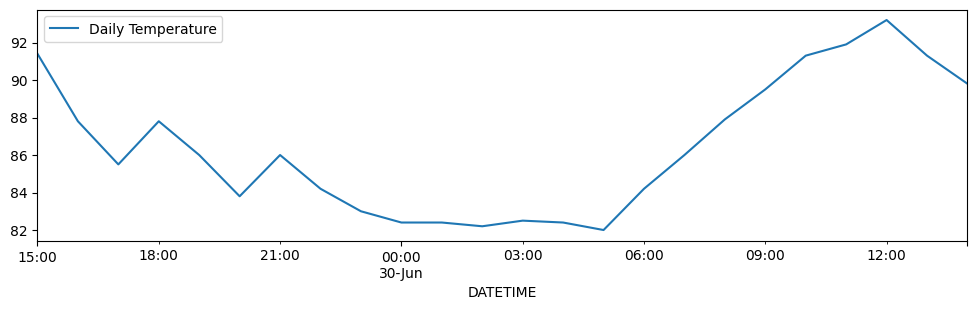

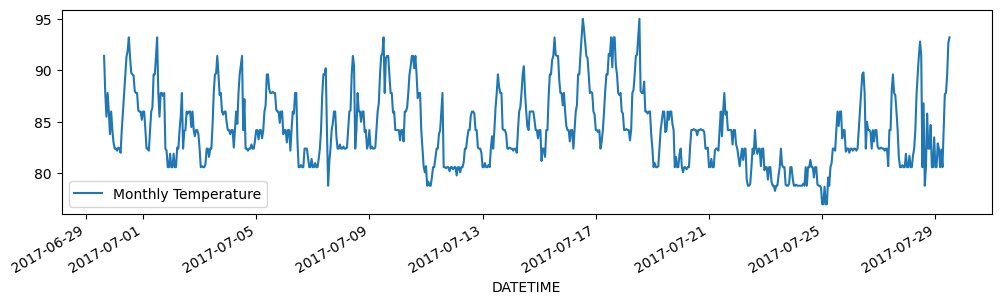

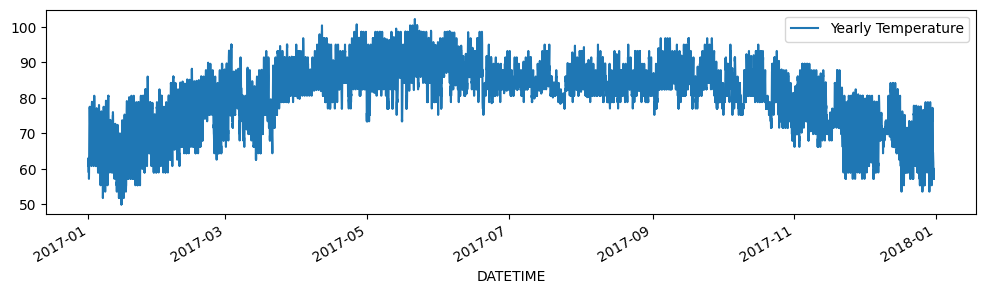

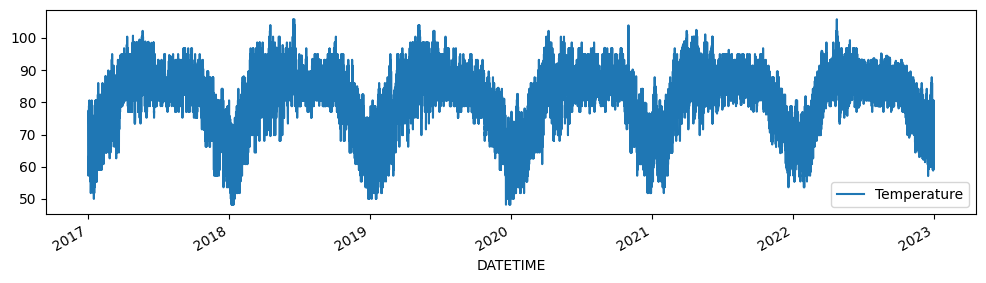

In [13]:
show_trends("Temperature")

### Humidity

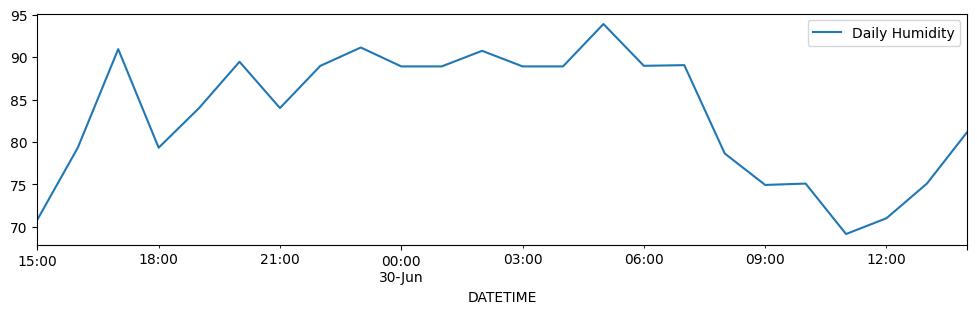

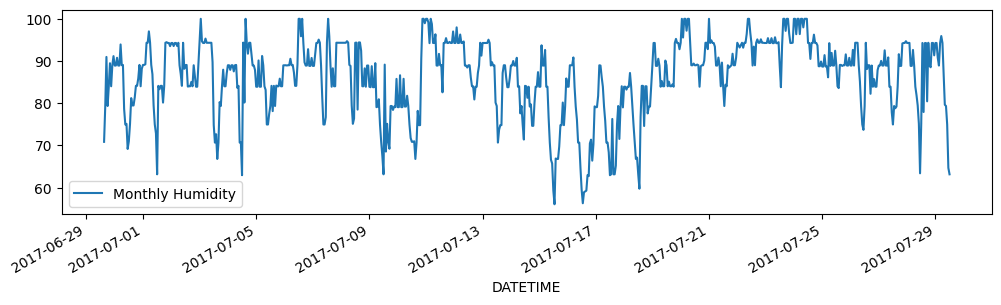

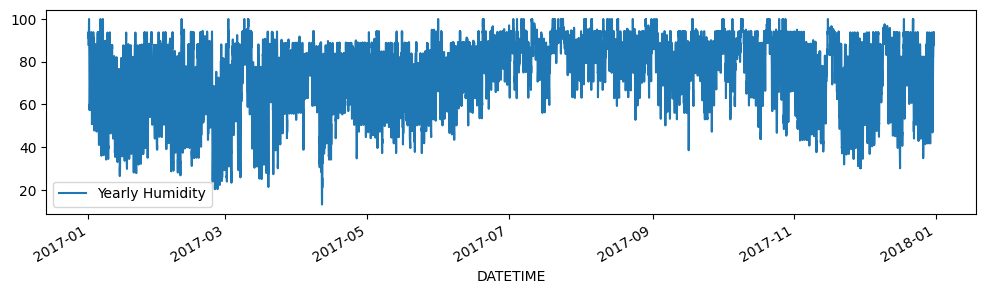

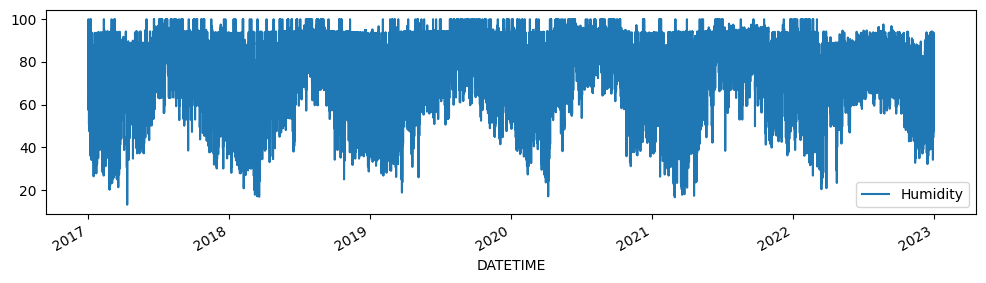

In [14]:
show_trends("Humidity")

### Precipitation

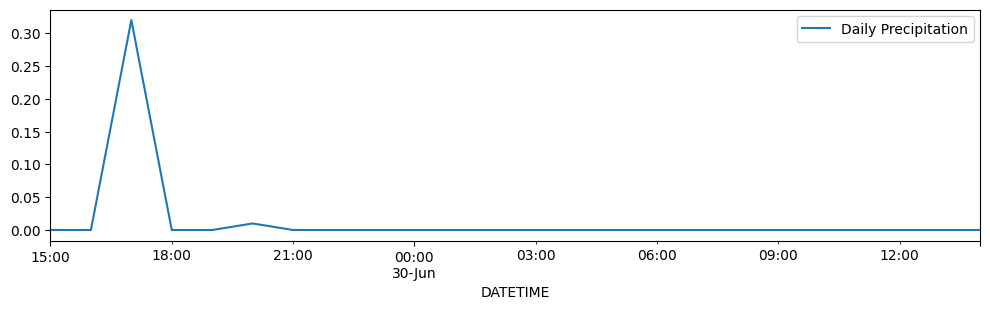

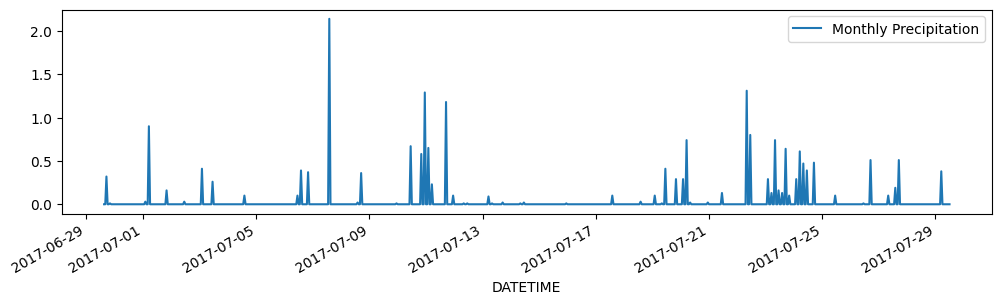

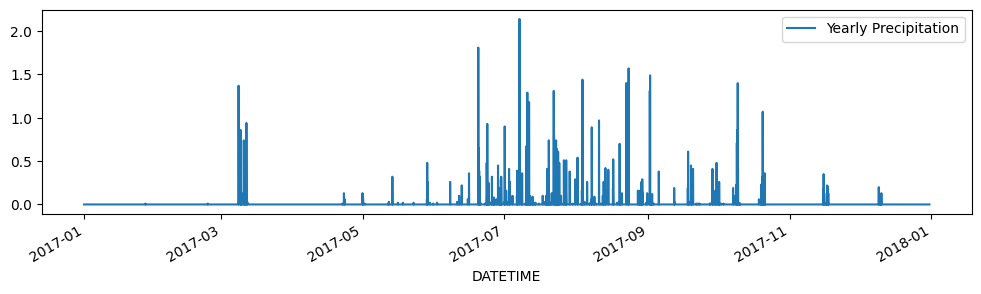

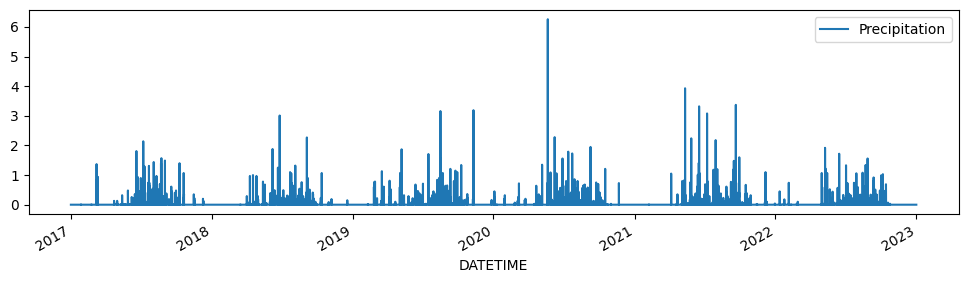

In [15]:
show_trends("Precipitation")

### Sea Level Pressure

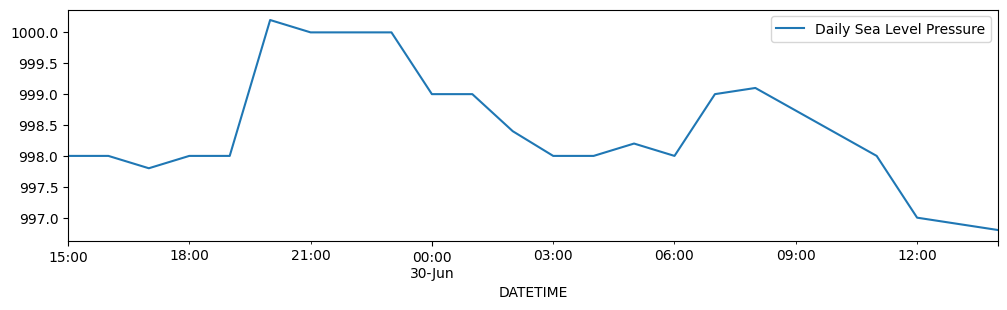

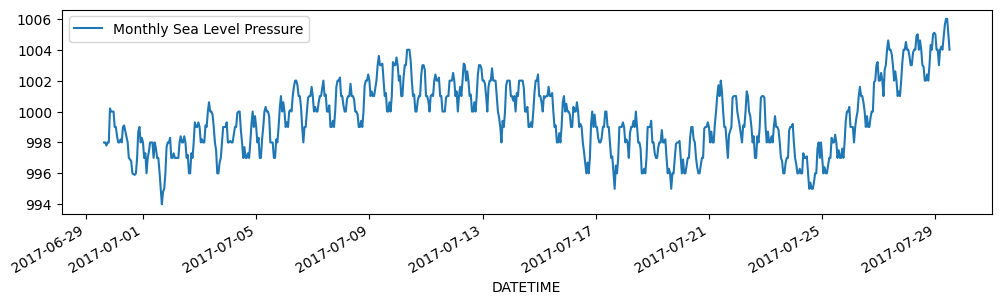

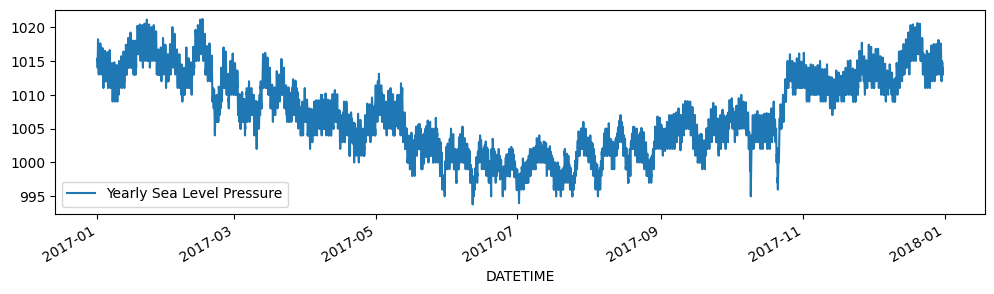

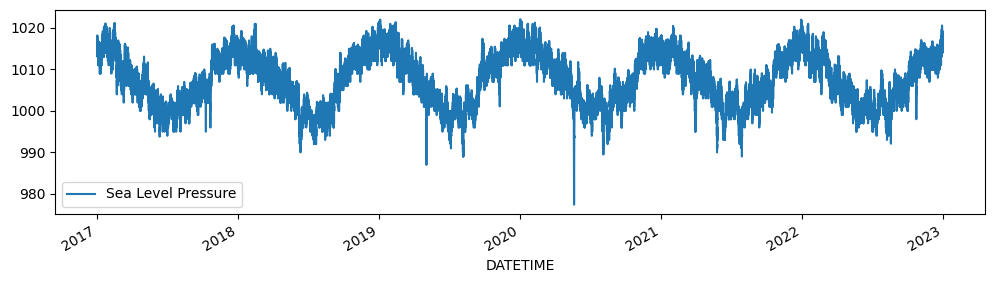

In [16]:
show_trends("Sea Level Pressure")

### Cloud Cover

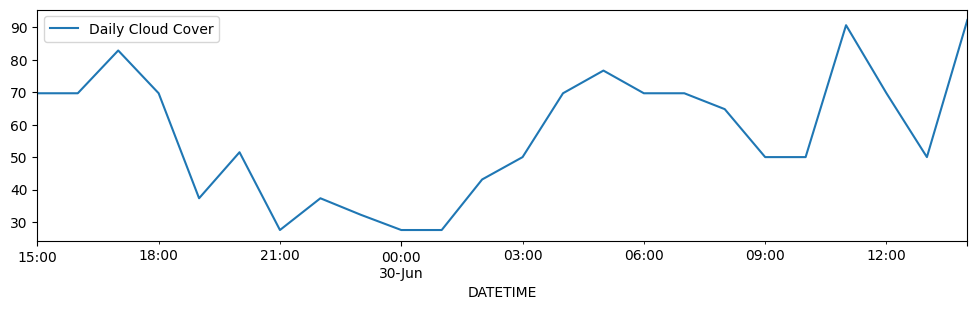

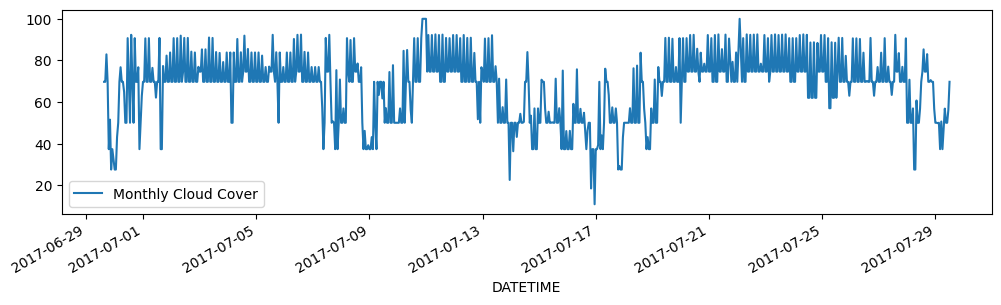

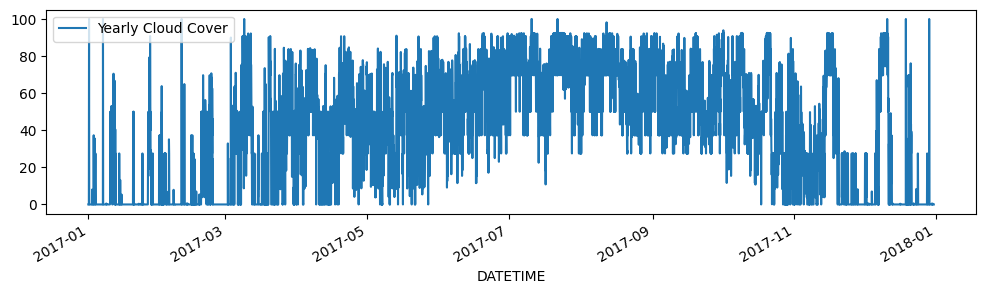

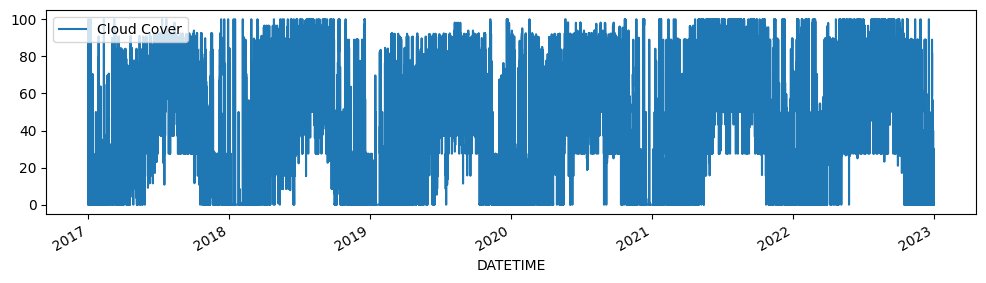

In [17]:
show_trends("Cloud Cover")

## Analogy
- these column certainly have some periodicity over the hours of day 
- also periodicity over the days of the year
- we can use this analogy to design the data such that it perfectly represents the periodic nature of day and year

### Box plot

In [18]:
def generate_boxplot(df, columns):
    fig, ax = plt.subplots()
    ax.boxplot(df[columns].values, labels=columns)
    ax.set_title('Box plot of {}'.format(', '.join(columns)))
    ax.set_ylabel('Value')
    plt.show()

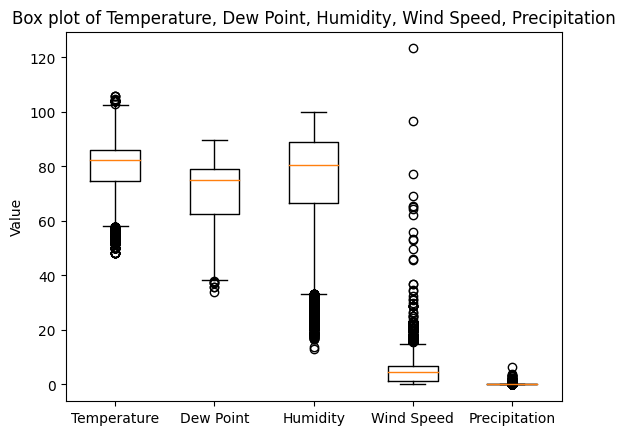

In [19]:
generate_boxplot(df, ['Temperature', 'Dew Point', 'Humidity', 'Wind Speed', 'Precipitation'])

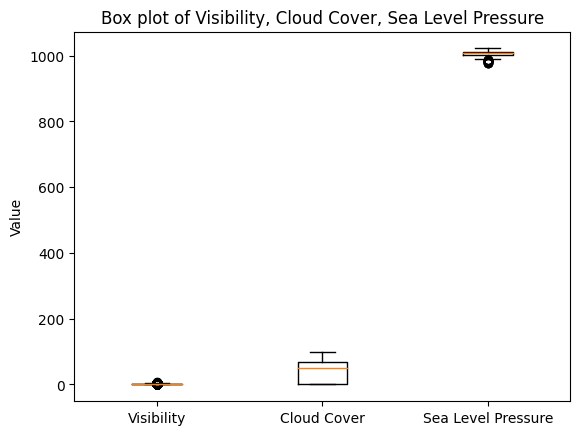

In [20]:
generate_boxplot(df, ["Visibility", "Cloud Cover", "Sea Level Pressure"])

**Analogy**
- Temperature: The median temperature is around 82.4 degrees Fahrenheit, with a range of 48.2 to 105.8 degrees Fahrenheit. There are some outliers on the lower and higher end of the temperature range.
- Dew Point: The median dew point is around 75.2 degrees Fahrenheit, with a range of 33.8 to 89.6 degrees Fahrenheit. There are some outliers on the lower and higher end of the dew point range.
- Relative Humidity: The median relative humidity is around 80.6%, with a range of 13.2% to 100%. There are some outliers on the lower end of the relative humidity range.
- Wind Speed: The median wind speed is around 4.7 mph, with a range of 0 to 123.3 mph. There are some outliers on the higher end of the wind speed range.
- Wind Direction: The median wind direction is around 160 degrees, with a range of 0 to 360 degrees. The distribution is somewhat uniform across the range.
- Precipitation: The median precipitation is very low, at only 0.0 inches, with a range of 0.0 to 6.26 inches. There are many outliers on the higher end of the precipitation range.
- Visibility: The median visibility is 1.9 miles, with a range of 0.0 to 8.6 miles. There are some outliers on the lower end of the visibility range.
- Cloud Cover: The median cloud cover is around 50%, with a range of 0 to 100%. The distribution is somewhat uniform across the range.
- Sea Level Pressure: The median sea level pressure is around 1008.0 mb, with a range of 977.4 to 1022.1 mb. There are some outliers on the lower end of the sea level pressure range.
- wind speed, precipitation etc has very low weightage in comparison with high valued columns like temperature, humidity and sea level pressure. So, the data columns need to be scaled down.

#### Circular Plot

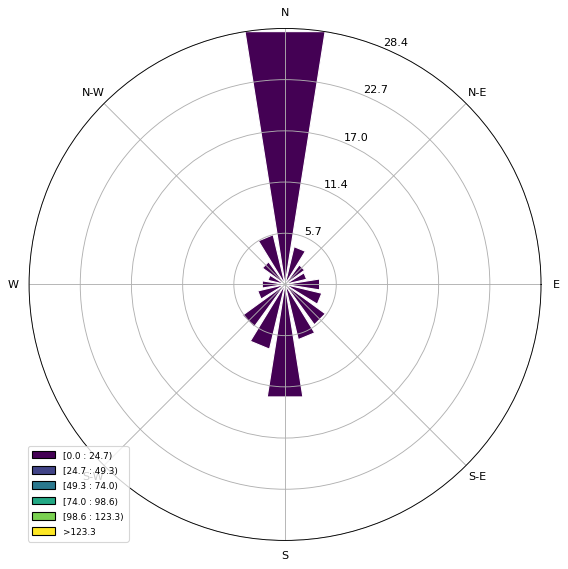

In [21]:
# Create a windrose plot
ax = WindroseAxes.from_ax()
ax.bar(df['Wind Direction'], df['Wind Speed'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()

# Show the plot
plt.show()

**Analogy** 
- wind speed is low as we can see from df.describe() that 75% of data is below 7 KMPH
- wind direction is mostly towards north

## Data Manipulation

### Changing wind direction

In [22]:
angle = (df["Wind Direction"]*np.pi)/360
df.drop("Wind Direction", axis=1, inplace=True)
df["sin(wind)"] = np.sin(df["Wind Direction"])
df["cos(wind)"] = np.cos(df["Wind Direction"])

KeyError: 'Wind Direction'

#### Changing the string data into usable ordinal values

In [ ]:
set(df["Conditions"])

In [ ]:
set([w.strip() for weather in df["Weather Type"] for w in weather.split(',')])

In [ ]:
# create a dictionary of numerical values
rain_values = {'Heavy Rain': 7, 'Snow And Rain Showers': 6,
                  'Rain Showers': 5, 'Rain': 4, 'Light Rain': 3, 'Light Drizzle': 2, 'Drizzle': 1}

storm_values = {
    'Dust storm':1,
    'Lightning Without Thunder':2,
    'Thunderstorm Without Precipitation':3,
    'Thunderstorm': 4,
}

overview = {
    'Clear':1,
    'Partially cloudy':2,
    'Rain':2,
    'Overcast':3,
}

# function to map weather values to numerical values
def map_weather_to_numerical(weather, ordinal_values):
    val = 0
    for w in weather.split(","):
        w = w.strip()
        if w in ordinal_values:
            val = max(ordinal_values[w], val)
    
    return val

# create a new column with numerical values
df["Rain"] = df['Weather Type'].apply(lambda s: map_weather_to_numerical(s, rain_values))
df["Storm"] = df['Weather Type'].apply(lambda s: map_weather_to_numerical(s, storm_values))
df["Overview"] = df['Conditions'].apply(lambda s: map_weather_to_numerical(s, overview))

df.head()

In [ ]:
df[["Rain", "Storm", "Overview"]].describe()

conclusion - the std of rain and storm is near to 1 which means the rain and storm column might have some outliers

In [ ]:
df.drop(["Weather Type", "Conditions"], axis=1, inplace=True)

### DATETIME => Seconds

In [ ]:
df["seconds"] = df["DATETIME"].map(pd.Timestamp.timestamp)
df.drop("DATETIME", axis=1, inplace=True)
df.head()

### Processing the seconds to represent the periodic nature of days and years

In [ ]:
day_in_seconds = 24*3600
year_in_seconds = day_in_seconds * 365.2425
df["sin(day)"] = np.sin((df["seconds"]*(2*np.pi))/day_in_seconds) #-----------> radian_per_day = (2*np.pi)/(day_in_seconds)
df["cos(day)"] = np.cos((df["seconds"]*(2*np.pi))/day_in_seconds)
df["sin(year)"] = np.sin((df["seconds"]*(2*np.pi))/year_in_seconds) #---------> radian_per_year = (2*np.pi)/(365.2425*24)
df["cos(year)"] = np.cos((df["seconds"]*(2*np.pi))/year_in_seconds)
df.drop("seconds", axis=1, inplace=True)
df.head()

## Correlation Analysis

In [ ]:
corr_matrix = df.corr()
print(corr_matrix)

In [ ]:
fig, ax = plt.subplots(figsize=(12,12)) 
sns.heatmap(df.corr(), annot=True)

### Analogy
This is the correlation matrix of the numerical columns in your DataFrame. The values range from -1 to 1, where -1 indicates a strong negative correlation, 0 indicates no correlation, and 1 indicates a strong positive correlation. Here are some insights you can gather from this matrix:

- Temperature is strongly positively correlated with Dew Point and Visibility, meaning that as temperature increases, dew point and visibility also tend to increase.
- Temperature is strongly negatively correlated with Relative Humidity and Sea Level Pressure, meaning that as temperature increases, relative humidity and sea level pressure tend to decrease.
- Dew Point is strongly negatively correlated with Sea Level Pressure, meaning that as dew point increases, sea level pressure tends to decrease.
- Visibility is moderately negatively correlated with Relative Humidity and Cloud Cover, meaning that as visibility decreases, relative humidity and cloud cover tend to increase.
- Cloud Cover is moderately positively correlated with Dew Point and Visibility, meaning that as cloud cover increases, dew point and visibility tend to increase.

In [ ]:
def plot_scatter_density(df, output, corr_thresh=0.6, size=3):
    # Create a correlation matrix
    corr_matrix = df.corr()

    # Get the names of highly correlated variables
    high_corr_vars = set()
    high_corr_vars.add(output)
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >= corr_thresh:
                colname = corr_matrix.columns[i]
                high_corr_vars.add(colname)
                
    print((high_corr_vars))
    sns.pairplot(data=df[list(high_corr_vars)], kind='scatter', hue=output)
    

### Temperature variability

In [ ]:
plot_scatter_density(df, "Temperature")

### Humidity variability

In [ ]:
plot_scatter_density(df, "Humidity")

### Creating X and Y

In [ ]:
def df_to_xy(df, output_cols, frame_size=6, offset=6):
    df_numpy = df.to_numpy()
    X = []
    Y = []
    for i in range(len(df)-frame_size-offset):
        row = [t_th_vals for t_th_vals in df_numpy[i:i+frame_size]]
        label = [df_numpy[i+frame_size+offset][col] for col in output_cols]
        X.append(row)
        Y.append(label)
    return np.array(X), np.array(Y)

### standardize the data

In [ ]:
def mean_std(X, num_features):
    mean = [np.mean(X[:,:,i]) for i in range(num_features)]
    std = [np.std(X[:,:,i]) for i in range(num_features)]
    return np.array(mean), np.array(std)

def standardizeX(X, mean, std):
    for i in range(len(mean)):
        X[:,:,i] = (X[:, :, i]-mean[i])/std[i]
    return X

def standardizeY(Y, mean, std, col_inds):
    for i in range(len(col_inds)):
        Y[:,i] = (Y[:, i]-mean[col_inds[i]])/std[col_inds[i]]
    return Y

def revY(Y, mean, std, col_inds):
    Y = (Y*std[col_inds]) + mean[col_inds]
    return Y

#### Train, Val, Test split

In [ ]:
def split_data(
    X,Y,
    train_size = 0.75,
    val_size = 0.05):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    return (X_train, Y_train, X_test, Y_test)

# Train and test data

#### Global vars

In [ ]:
num_features = df.shape[-1]
frame_size = 24
offset=12

In [ ]:
def create_xy(df, output_cols, num_features, frame_size=24, offset=12):
    print(output_cols)
    col_inds = [i for i in range(num_features) if df.columns[i] in output_cols]
    X, Y = df_to_xy(df, col_inds, frame_size, offset)
    
    (X_train, Y_train, X_test, Y_test) = split_data(X, Y)
    
    mean, std = mean_std(X_train, num_features)
    X = standardizeX(X, mean, std)
    Y = standardizeY(Y, mean, std, col_inds)
#     print(X.shape, Y.shape)
    (X_train, Y_train, X_test, Y_test) = split_data(X, Y)
    
    pickle.dump({"mean":mean, "std":std}, open("mean_std.pkl", 'wb'))
    
    return X_train, Y_train, X_test, Y_test, mean, std, col_inds


# Model

### Hyperparameter tuning

In [ ]:
# Define the model building function
def build_model(hp):
    model = keras.Sequential()
    
    # Tune the number of LSTM layers
    for i in range(hp.Int('num_lstm_layers', 1, 3)):
        model.add(layers.LSTM(units=hp.Int(f'lstm_{i}_units', 12, 64, 4),
                              return_sequences=True if i < hp.get('num_lstm_layers') - 1 else False))
    
    # Tune the number of Dense layers and units
    for i in range(hp.Int('num_dense_layers', 1, 3)):
        model.add(layers.Dense(units=hp.Int(f'dense_{i}_units', 8, 64, 4), activation='relu'))
    
    model.add(layers.Dropout(hp.Float('dropout', 0.0, 0.5, step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 0.001, 0.1, step=0.01)),
        loss='mean_squared_error',
        metrics=['mean_squared_error', 'accuracy'])
    
    return model

In [ ]:
def get_best_tuned_model(
    workdir = "/kaggle/working/my_dir",
    project_name="temp", 
    input_shape=(None, frame_size, num_features)):
    
    
    tuner = kt.Hyperband(
        hypermodel=build_model,
        objective='val_mean_squared_error',
        max_epochs=20,
        factor=3,
        directory=workdir,
        project_name=project_name
    )
    
    best_model_count = 10
    bo_tuner_best_models = tuner.get_best_models(num_models=best_model_count)
    
    best_model_id = 0
    model = bo_tuner_best_models[best_model_id]
    model.build(input_shape=input_shape)
    
    return model

In [ ]:
def get_score(model, output_cols=["Temperature"]):
    X_train, Y_train, X_test, Y_test, mean, std, col_inds = create_xy(df, output_cols, num_features, frame_size=frame_size)
    Y_test_pred = model.predict(X_test)
    Y_train_pred = model.predict(X_train)
    
    print("Accuracy ;-")
    print("Train Score :")
    for i in range(len(output_cols)):
        print(output_cols[i]+":",r2_score(Y_train[:,i], Y_train_pred[:,i]))
        
    print("Test Score :")
    for i in range(len(output_cols)):
        print(output_cols[i]+":",r2_score(Y_test[:,i], Y_test_pred[:,i]))
   
    return Y_test, Y_test_pred


In [ ]:
X_train, Y_train, X_test, Y_test, mean, std, col_inds = create_xy(df, ["Temperature"], num_features, frame_size=frame_size)
# Define the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_mean_squared_error',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='temp')

# Define the callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
]

# Start the hyperparameter search
tuner.search(X_train, Y_train,
             epochs=20,
             validation_data=(X_test, Y_test),
             callbacks=callbacks)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

In [ ]:
temp_model = get_best_tuned_model(project_name="temp")
our_temp_test, our_temp_pred = get_score(temp_model, output_cols=["Temperature"])

In [ ]:
plot_model(temp_model, to_file='temp_model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
X_train, Y_train, X_test, Y_test, mean, std, col_inds = create_xy(df, ["Humidity"], num_features, frame_size=frame_size)

# Define the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_mean_squared_error',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='hum')

# Define the callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
]

# Start the hyperparameter search
tuner.search(X_train, Y_train,
             epochs=20,
             validation_data=(X_test, Y_test),
             callbacks=callbacks)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

In [ ]:
hum_model = get_best_tuned_model(project_name="hum")
our_hum_test, our_hum_pred = get_score(hum_model, output_cols=["Humidity"])

In [ ]:
plot_model(hum_model, to_file='hum_model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
import pickle
pickle.dump(temp_model, open("temp_model.pkl", 'wb'))
pickle.dump(hum_model, open("hum_model.pkl", 'wb'))

# Evaluation

In [ ]:
from sklearn.preprocessing import StandardScaler

# Instantiate the scaler
scaler = StandardScaler()

# Normalize the dataframe
standardized_data = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [ ]:
X_temp = standardized_data.drop(["Temperature"], axis=1)[:-offset]
Y_temp = standardized_data["Temperature"][offset:]
X_hum = standardized_data.drop(["Humidity"], axis=1)[:-offset]
Y_hum = standardized_data["Humidity"][offset:]

In [ ]:
X_temp_train, X_temp_test, y_temp_train, y_temp_test = train_test_split(X_temp, Y_temp, test_size=0.2, random_state=42)
X_hum_train, X_hum_test, y_hum_train, y_hum_test = train_test_split(X_hum, Y_hum, test_size=0.2, random_state=42)

In [ ]:
X_hum_train.head()

In [ ]:
# Temperature SVM model
temp_svm = SVR(kernel='linear')
temp_svm.fit(X_temp_train, y_temp_train)
temp_svm_pred = temp_svm.predict(X_temp_test)

# Humidity SVM model
hum_svm = SVR(kernel='linear')
hum_svm.fit(X_hum_train, y_hum_train)
hum_svm_pred = hum_svm.predict(X_hum_test)

In [ ]:
# Temperature Random Forest model
temp_rf = RandomForestRegressor(n_estimators=100, random_state=42)
temp_rf.fit(X_temp_train, y_temp_train)
temp_rf_pred = temp_rf.predict(X_temp_test)

# Humidity Random Forest model
hum_rf = RandomForestRegressor(n_estimators=100, random_state=42)
hum_rf.fit(X_hum_train, y_hum_train)
hum_rf_pred = hum_rf.predict(X_hum_test)


In [ ]:
def evaluation(
    model,
    temp_pred,
    hum_pred,
    y_temp_test=y_temp_test,
    y_hum_test=y_hum_test,
):
    # Temperature model evaluation
    temp_mse = mean_squared_error(y_temp_test, temp_pred)
    temp_rmse = (temp_mse)**(0.5)
    temp_mae = mean_absolute_error(y_temp_test, temp_pred)
    acc_temp = r2_score(y_temp_test, temp_pred)
    
    
    # Humidity model evaluation
    hum_mse = mean_squared_error(y_hum_test, hum_pred)
    hum_rmse = (hum_mse)**(0.5)
    hum_mae = mean_absolute_error(y_hum_test, hum_pred)
    acc_hum = r2_score(y_hum_test, hum_pred)
    
    
    # Print the results
    print('Temperature {}: MSE = {}, RMSE = {}, MAE = {}, accuracy = {}'.format(model,temp_mse, temp_rmse, temp_mae, acc_temp))
    print('Humidity {}: MSE = {}, RMSE = {}, MAE = {}, accuracy = {}'.format(model, hum_mse, hum_rmse, hum_mae, acc_hum))
        
    print("\n\n")

In [ ]:
evaluation("SVM", temp_svm_pred, hum_svm_pred)
evaluation("Random_Forest", temp_rf_pred, hum_rf_pred)
evaluation("Our Model", our_temp_pred, our_hum_pred, our_temp_test, our_hum_test)